In [2]:
# Imports
from lib.utils import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn.functional import relu,one_hot
from tqdm import tqdm
device = 'cuda'
torch.cuda.empty_cache()

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
X,y = load_raw_list([20,21,22])

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,shuffle=True,stratify=y,random_state=0)

In [5]:
y_train_one_hot = one_hot(y_train,num_classes=3).reshape(-1,3).float()
y_test_one_hot = one_hot(y_test,num_classes=3).reshape(-1,3).float()
X_train = X_train.reshape(-1,1,5000)
y_train_one_hot = y_train_one_hot
X_test = X_test.reshape(-1,1,5000)
y_test_one_hot = y_test_one_hot
from torch.utils.data import TensorDataset
training_data = TensorDataset(X_train,y_train_one_hot)
testing_data = TensorDataset(X_test,y_test_one_hot)
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=256, shuffle=True)

In [6]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.c1 = nn.Conv1d(1, 16, kernel_size=100, stride=10, padding=1)
        self.c2 = nn.Conv1d(16, 8, kernel_size=100, stride=10, padding=1)
        self.fc1 = nn.Linear(56, 3)
        self.fc1.bias = torch.nn.Parameter(data=torch.Tensor([.1,1,1]))
        print(self.fc1.bias)

    def forward(self,x):
        x = self.c1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = self.c2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = x.view(-1, 56)
        x = self.fc1(x)
        
        return x
model = MLP().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Parameter containing:
tensor([0.1000, 1.0000, 1.0000], requires_grad=True)


In [7]:
model(X_train[0].reshape(-1,1,5000).cuda()).shape

torch.Size([1, 3])

In [8]:
train_losses = []
test_losses = []

In [9]:
training_loss = 0
model.train()
for (X,y) in train_dataloader:
    X,y = X.to(device), y.to(device)
    logits = model(X)
    loss = criterion(logits,y)
    training_loss += loss.item()
training_loss/len(train_dataloader)

0.931837358592469

In [22]:
for epoch in range(100):
    training_loss = 0
    model.train()
    for (X,y) in train_dataloader:
        X,y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    if(epoch%10 == 0):
        train_losses.append(training_loss/len(train_dataloader))
        model.eval()
        testing_loss = 0
        for (X,y) in test_dataloader:
            X,y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits,y)
            testing_loss += loss.item()
        test_losses.append(testing_loss/len(test_dataloader))
        print(f'Epoch {epoch} Train: {training_loss/len(train_dataloader)} Test: {testing_loss/len(test_dataloader)}')

Epoch 0 Train: 0.25703535550906337 Test: 0.28846733626865206
Epoch 10 Train: 0.25161508903091334 Test: 0.28334936570553554
Epoch 20 Train: 0.25021689136823017 Test: 0.2907770801158178
Epoch 30 Train: 0.24845522752514593 Test: 0.28750965283030555
Epoch 40 Train: 0.25367384946640625 Test: 0.3180109517914908
Epoch 50 Train: 0.2575793538564517 Test: 0.2885015748796009
Epoch 60 Train: 0.2506420393416911 Test: 0.2815968443950017
Epoch 70 Train: 0.24913901403362368 Test: 0.2829891606455758
Epoch 80 Train: 0.2461131305238347 Test: 0.28561837048757643
Epoch 90 Train: 0.2395814013333968 Test: 0.2974187483390172


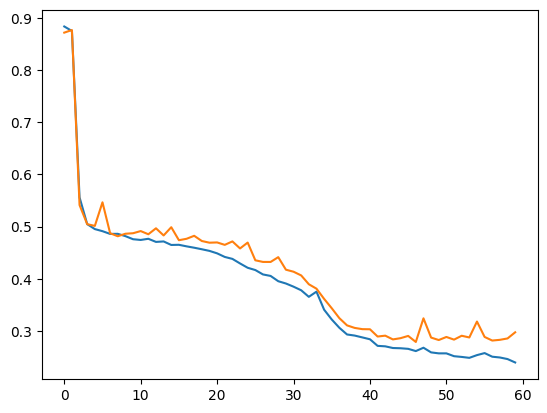

In [23]:
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='validation')
plt.savefig('loss.jpg',dpi=200)

In [24]:
import seaborn as sns
sm = nn.Softmax(dim=1)
y_pred_train = []
y_pred_test = []
for sample in X_train:
    y_pred_train.append(sm(model(sample.cuda())).argmax(axis=1).item())
for sample in X_test:
    y_pred_test.append(sm(model(sample.cuda())).argmax(axis=1).item())

0.8933050356936137

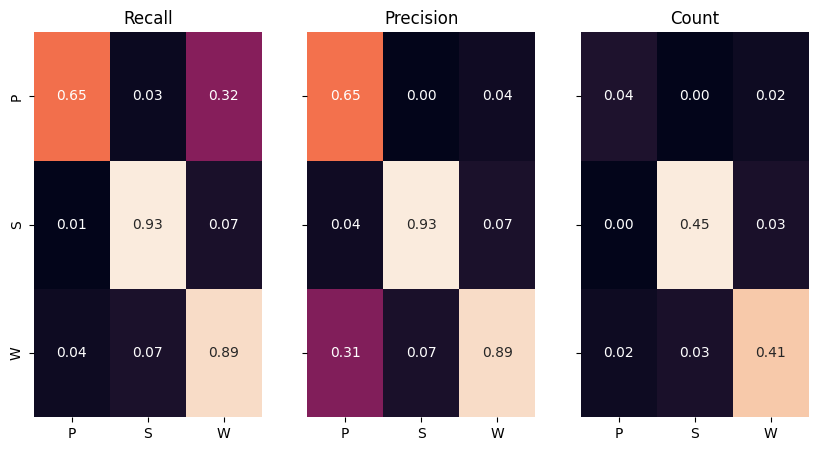

In [25]:
from sklearn.metrics import confusion_matrix
fig,axes = plt.subplots(1,3,sharey=True,figsize=(10,5))
sns.heatmap(confusion_matrix(y_test,y_pred_test,normalize='true'),annot=True,ax=axes[0],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_test,y_pred_test,normalize='pred'),annot=True,ax=axes[1],cbar=False,fmt='.2f')
sns.heatmap(confusion_matrix(y_test,y_pred_test,normalize='all'),annot=True,ax=axes[2],cbar=False,fmt='.2f')
axes[0].set_title('Recall')
axes[1].set_title('Precision')
axes[2].set_title('Count')
axes[0].set_xticklabels(['P','S','W'])
axes[1].set_xticklabels(['P','S','W'])
axes[2].set_xticklabels(['P','S','W'])
axes[0].set_yticklabels(['P','S','W'])
plt.savefig('cm.jpg',dpi=200,bbox_inches='tight')
from sklearn.metrics import balanced_accuracy_score,accuracy_score
accuracy_score(y_true=y_test,y_pred=y_pred_test)

In [ ]:
fig,axes = plt.subplots(nrows=len(model.c1.weight),ncols=1,figsize=(32,18))
for i in range(len(model.c1.weight)):
    axes[i].plot(model.c1.weight[i].squeeze().detach().cpu())
plt.savefig('kernels.jpg',dpi=500)

In [ ]:
torch.save(obj=model,f='model.pt')